In [3]:
%cd "F:/University/Master's Thesis/Datasets"

F:\University\Master's Thesis\Datasets


In [ ]:
%pip install pytorch-lightning
%pip install lightning

In [4]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [5]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

# Load BGL dataset into a DataFrame (Replace 'path_to_your_file' with the actual file path)
file_path = 'bgl_structured_data.csv'
df = pd.read_csv(file_path)
df.head(5)

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1186991,-,1119695655,2005.06.25,R32-M0-NA-C:J14-U11,2005-06-25-03.34.15.417108,R32-M0-NA-C:J14-U11,RAS,KERNEL,INFO,254619084 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['254619084']
1,1186992,-,1119695655,2005.06.25,R32-M0-NA-C:J10-U11,2005-06-25-03.34.15.438456,R32-M0-NA-C:J10-U11,RAS,KERNEL,INFO,255442463 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['255442463']
2,1186993,-,1119695655,2005.06.25,R32-M0-NA-C:J10-U11,2005-06-25-03.34.15.451519,R32-M0-NA-C:J10-U11,RAS,KERNEL,INFO,256867576 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['256867576']
3,1186994,-,1119695655,2005.06.25,R32-M0-NA-C:J06-U11,2005-06-25-03.34.15.472919,R32-M0-NA-C:J06-U11,RAS,KERNEL,INFO,255099253 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['255099253']
4,1186995,-,1119695655,2005.06.25,R32-M0-NA-C:J06-U11,2005-06-25-03.34.15.486042,R32-M0-NA-C:J06-U11,RAS,KERNEL,INFO,258522516 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['258522516']


In [6]:
df["Time"] = pd.to_datetime(df["Time"], format='%Y-%m-%d-%H.%M.%S.%f')

# Calculate time_idx for seconds
df["time_idx"] = (
    df["Time"].dt.year * 365 * 24 * 60 * 60 +  # Convert years to seconds
    df["Time"].dt.month * 30 * 24 * 60 * 60 +  # Convert months to seconds (assuming 30 days per month)
    df["Time"].dt.day * 24 * 60 * 60 +  # Convert days to seconds
    df["Time"].dt.hour * 60 * 60 +  # Convert hours to seconds
    df["Time"].dt.minute * 60 +  # Convert minutes to seconds
    df["Time"].dt.second  # Seconds
)

# Adjust time_idx to start from 0
df["time_idx"] -= df["time_idx"].min()
df = df.sort_values(by="time_idx")

# Assuming 'df' is your DataFrame
df = df.drop_duplicates(subset=['time_idx', 'Node', "EventId"], keep=False)


In [7]:
# Display the DataFrame with the new time_idx column
print(df[["Node", "Level", "time_idx", "Component", "EventTemplate"]])

                        Node Level  time_idx Component  \
1644188  R02-M1-N0-C:J12-U11  INFO        15    KERNEL   
1644253  R02-M1-N0-C:J12-U11  INFO        38    KERNEL   
1644260  R02-M1-N0-C:J12-U11  INFO        40    KERNEL   
1644269  R02-M1-N0-C:J12-U11  INFO        44    KERNEL   
1644292  R02-M1-N0-C:J12-U11  INFO        52    KERNEL   
...                      ...   ...       ...       ...   
2356265  R37-M1-N0-C:J02-U11  INFO  15353606    KERNEL   
2356266  R51-M1-N0-C:J08-U11  INFO  15353606    KERNEL   
2356267  R37-M0-N0-C:J05-U11  INFO  15353606    KERNEL   
2356259  R10-M1-NC-C:J05-U01  INFO  15353606    KERNEL   
2356251  R57-M1-N7-C:J11-U11  INFO  15353606    KERNEL   

                                             EventTemplate  
1644188           instruction cache parity error corrected  
1644253           instruction cache parity error corrected  
1644260           instruction cache parity error corrected  
1644269           instruction cache parity error corrected 

In [8]:
unique_values = df['EventId'].unique()
print(len(unique_values))

516


In [9]:
df['Node'].fillna('-', inplace=True)

In [10]:
labels, uniques = pd.factorize(df['EventId'])
df['EncodedEvents'] = labels

In [11]:
df['Node'] = df['Node'].astype('str')
df['Component'] = df['Component'].astype('str')
df['Level'] = df['Level'].astype('str')
df['EventId'] = df['EventId'].astype('str')
df['EventTemplate'] = df['EventTemplate'].astype('str')
df['EncodedEvents'] = df['EncodedEvents'].astype('int')

#df['Node'] = df['Node'].astype('category')
#df['Component'] = df['Component'].astype('category')
#df['Level'] = df['Level'].astype('category')
#df['EventId'] = df['EventId'].astype('category')
#df['EventTemplate'] = df['EventTemplate'].astype('category')

In [12]:
data_type = df['time_idx'].dtype
print("time_idx: " + str(data_type))

data_type = df['Node'].dtype
print("Node: " + str(data_type))

data_type = df['Component'].dtype
print("Component: " + str(data_type))

data_type = df['Level'].dtype
print("Level: " + str(data_type))

data_type = df['EventId'].dtype
print("EventId: " + str(data_type))

data_type = df['EventTemplate'].dtype
print("EventTemplate: " + str(data_type))

data_type = df['EncodedEvents'].dtype
print("EncodedEvents: " + str(data_type))

time_idx: int64
Node: object
Component: object
Level: object
EventId: object
EventTemplate: object
EncodedEvents: int32


In [13]:
# Replace 'Column_Name' with the name of the column you're interested in
empty_rows = df['Node'].isnull().sum()

print(f"Number of empty rows in 'Node': {empty_rows}")


Number of empty rows in 'Node': 0


In [14]:
df.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList,time_idx,EncodedEvents
1644188,237496,-,1117838585,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:05.980712,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],15,0
1644253,237561,-,1117838608,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:28.948656,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],38,0
1644260,237568,-,1117838610,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:30.008754,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],40,0
1644269,237577,-,1117838614,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:34.978903,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],44,0
1644292,237600,-,1117838622,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:42.042890,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],52,0


In [30]:
top_lengths = df['Node'].value_counts().head(30)
print(top_lengths)

R30-M0-N7-C:J09-U01    3912
R63-M0-N3-C:J02-U11    3816
R35-M0-N0-C:J07-U01    2972
R37-M1-NC-C:J02-U11    1824
R06-M1-N6-C:J15-U01    1812
R20-M1-NF-C:J10-U01    1618
R16-M1-N2-C:J17-U01    1555
R10-M0-N7-C:J17-U01    1518
R00-M1-NF-C:J13-U11    1246
R55-M0-N9-C:J06-U11    1217
R10-M1-N5-C:J04-U11     950
R07-M0-N6-C:J11-U01     898
R63-M1-NC-C:J06-U01     897
R21-M0-ND-C:J04-U01     767
R15-M1-N6-C:J04-U11     731
R03-M1-NF-C:J07-U01     697
R23-M0-N8-C:J15-U11     689
R01-M0-N8-C:J02-U11     686
R22-M1-N3-C:J06-U01     671
R73-M1-N1-C:J16-U11     670
R32-M0-NF-C:J14-U01     658
R61-M1-ND-C:J07-U11     656
R03-M1-N9-C:J09-U11     654
R11-M1-N3-C:J07-U11     647
R32-M1-N9-C:J16-U11     647
R25-M1-ND-C:J09-U01     646
R16-M1-N2-C:J16-U11     645
R17-M0-N0-C:J10-U01     635
R14-M1-N0-C:J07-U11     621
R20-M1-NB-C:J16-U11     616
Name: Node, dtype: int64


In [16]:
#nodes_to_remove = ['R30-M0-N9-C:J16-U01', 'R02-M1-N0-C:J12-U11', "-", "UNKNOWN_LOCATION", "R16-M1-N2-C:J17-U01", "R26-M0-N0-I:J18-U11", "R02-M0-N4-C:J04-U11"]  # Example list of nodes to remove
nodes_to_remove = ["UNKNOWN_LOCATION", "-"]  # Example list of nodes to remove

# Removing rows where 'Node' column matches specified nodes
df = df[~df['Node'].isin(nodes_to_remove)]

In [17]:
total_rows = len(df)  # Retrieves the length of the DataFrame (number of rows)
print("Total number of rows:", total_rows)


Total number of rows: 2553869


In [31]:
from pytorch_forecasting.data import TorchNormalizer

# create dataset and dataloaders
max_encoder_length = 3920
max_prediction_length = 800

training_cutoff = df["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="EncodedEvents",
    categorical_encoders={"Node": NaNLabelEncoder().fit(df.Node)},
    group_ids=["Node"],
    static_categoricals=[
        "Node"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_categoricals=[],  # Adjust this based on features
    time_varying_unknown_reals=["EncodedEvents"],  # Adjust this based on features
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    target_normalizer=TorchNormalizer()
)

validation = TimeSeriesDataSet.from_dataset(training, df)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [32]:
training.get_parameters()

{'time_idx': 'time_idx',
 'target': 'EncodedEvents',
 'group_ids': ['Node'],
 'weight': None,
 'max_encoder_length': 3920,
 'min_encoder_length': 3920,
 'min_prediction_idx': 15,
 'min_prediction_length': 800,
 'max_prediction_length': 800,
 'static_categoricals': ['Node'],
 'static_reals': ['encoder_length',
  'EncodedEvents_center',
  'EncodedEvents_scale'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['EncodedEvents'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': TorchNormalizer(method='standard', center=True, transformation=None, method_kwargs={}),
 'categorical_encoders': {'Node': NaNLabelEncoder(add_nan=False, warn=True),
  '__group_id__Node': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers

In [33]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 5 but got size 1 for tensor number 1 in the list.

In [34]:
import tensorflow as tf
import tensorboard as tb

In [35]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 6.9 M 
3 | rnn                    | LSTM                               | 23.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.762    Total estimated model params size (MB)


Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

RuntimeError: quantile() q tensor must be same dtype as the input tensor

In [23]:
# Choosing the best tft model from the checkpoints
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [24]:
# Saving the model to disk
import pickle

# save study results - also we can resume tuning at a later point in time
with open("tft_bgl_v2.pkl", "wb") as fout:
    pickle.dump(best_tft_model, fout)

In [20]:
import pickle

with open("tft_bgl_v2.pkl",'rb') as f:
    best_tft=pickle.load(f)
    

In [21]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(82.9756)

In [27]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


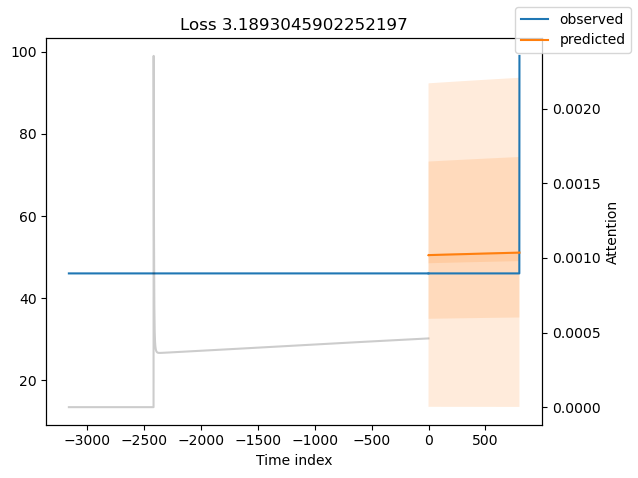

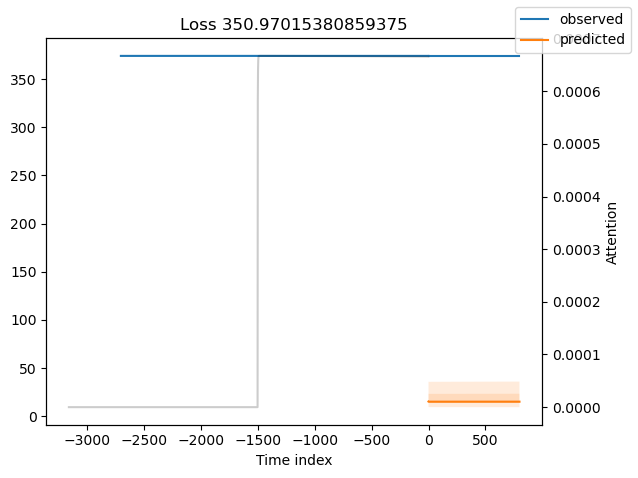

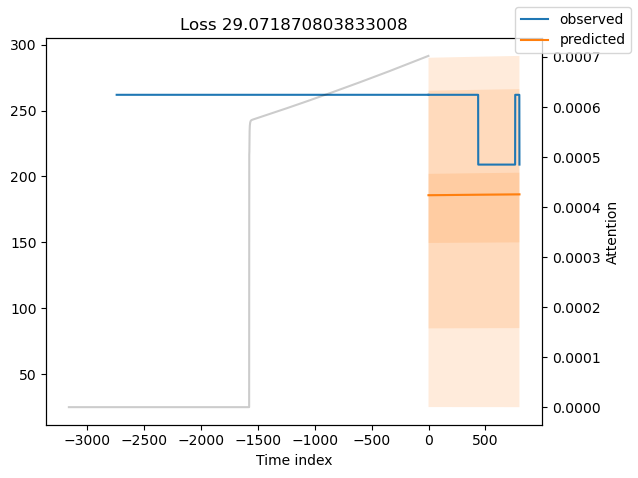

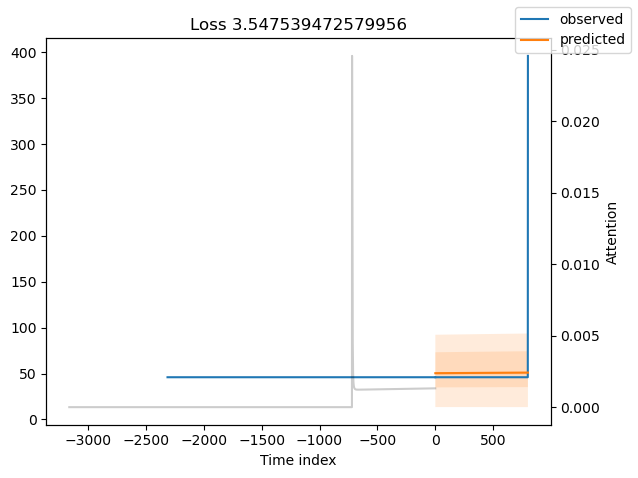

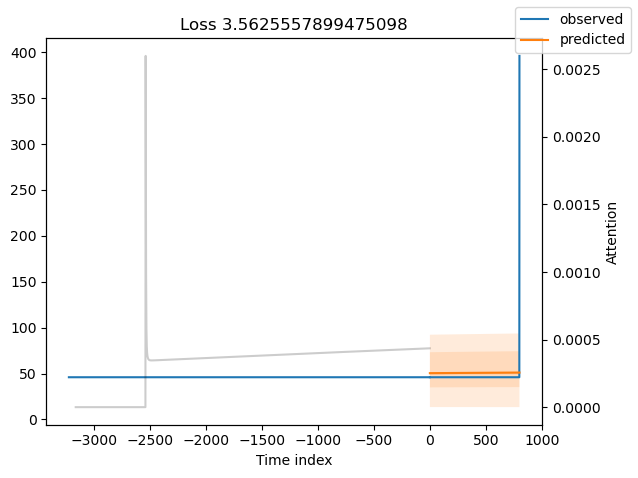

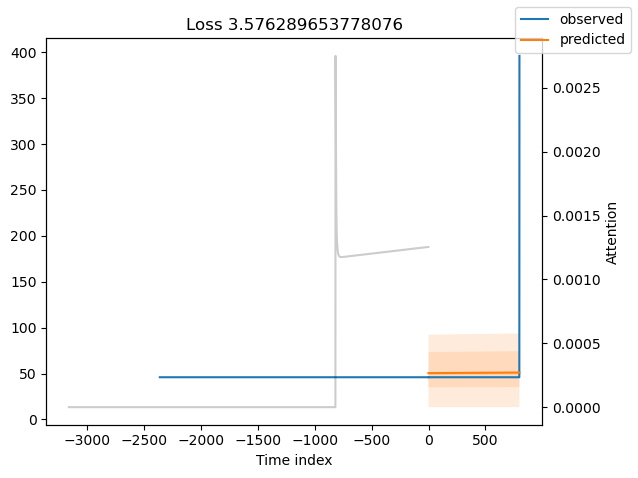

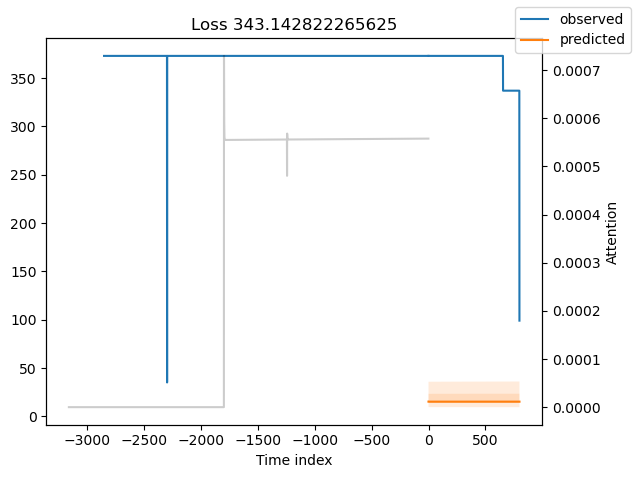

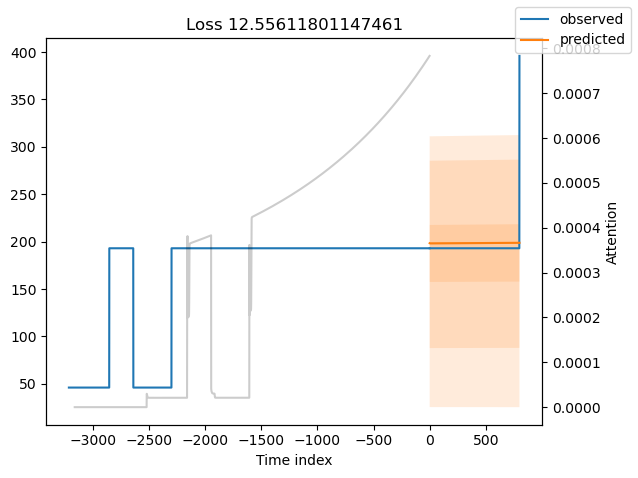

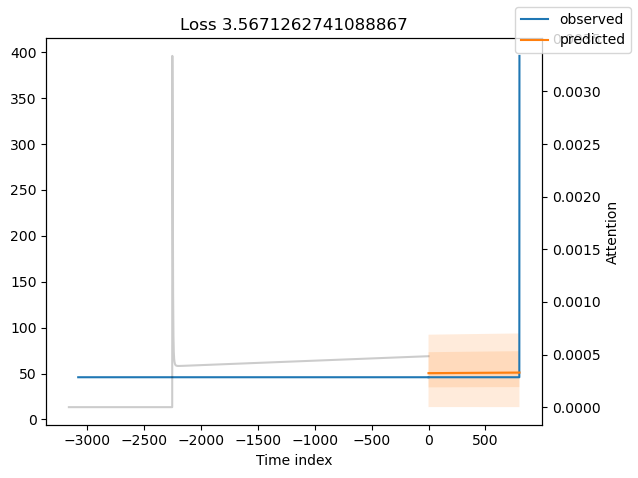

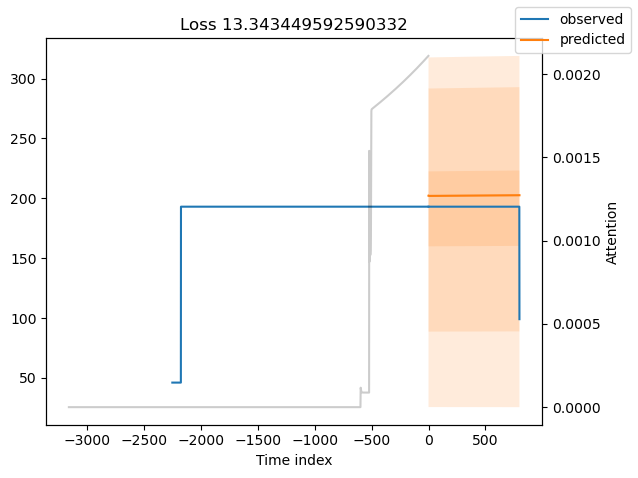

In [28]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

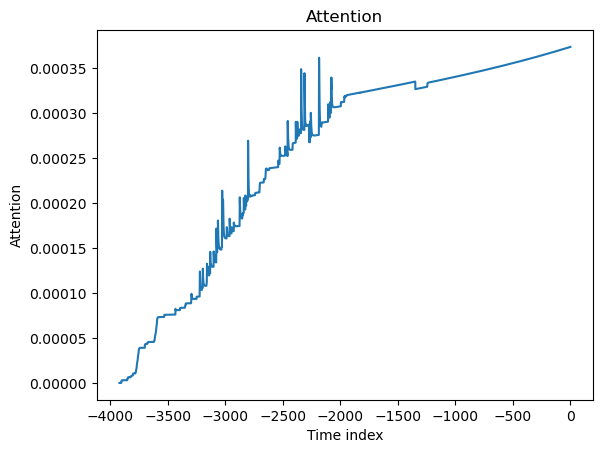

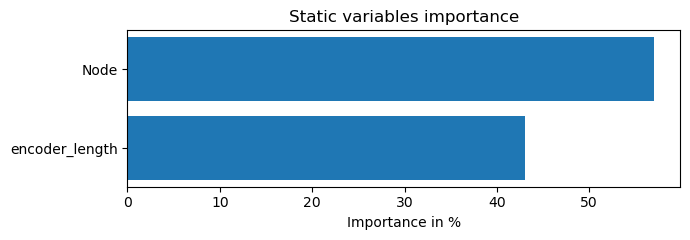

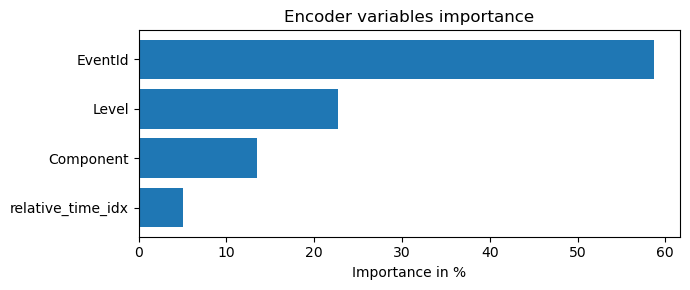

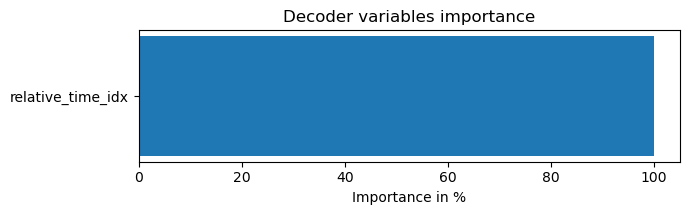

In [29]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [22]:
predictions = best_tft.predict(
    training.filter(lambda x: (x.Node == "R36-M1-NC-C:J17-U01") ),
    mode="prediction",return_y=True, return_index=True, return_decoder_lengths=True, return_x=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
for key, value in predictions.items():
    print(f"Field: {key}")
    if isinstance(value, torch.Tensor):
        print(f"Tensor shape: {value.shape}")
    else:
        print(f"Type: {type(value)}")

Field: output
Tensor shape: torch.Size([64, 800])
Field: x
Type: <class 'dict'>
Field: index
Type: <class 'pandas.core.frame.DataFrame'>
Field: decoder_lengths
Tensor shape: torch.Size([64])
Field: y
Type: <class 'tuple'>


In [24]:
# Assuming 'output' contains categorical predictions encoded with NaNLabelEncoder
decoded_output = training.target_normalizer.inverse_transform(predictions.output.argmax(dim=0).numpy())
print(decoded_output)

['18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f'
 '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625b4f' '18625

In [25]:
# Flatten the list using list comprehension
time_index = predictions.x["decoder_time_idx"][-1]

# Node name extraction from predictions
node_name = predictions.index['Node']  # Considering a single time index for now

# Extracting input data
input_data = predictions.x  # You might need to transform this dictionary into a string or relevant format

# Creating a DataFrame with all the information
result_df = pd.DataFrame({
    'EventId': decoded_output,
    'Time_Index': time_index,
    'Node': [node_name[0]] * len(decoded_output)
})

result_df= result_df.sort_values(by="Time_Index")
result_df.head(-1)

,EventId,Time_Index,Node
0,18625b4f,4741502,R36-M1-NC-C:J17-U01
1,18625b4f,4741503,R36-M1-NC-C:J17-U01
2,18625b4f,4741504,R36-M1-NC-C:J17-U01
3,18625b4f,4741505,R36-M1-NC-C:J17-U01
4,18625b4f,4741506,R36-M1-NC-C:J17-U01
...,...,...,...
794,0fa2051a,4742296,R36-M1-NC-C:J17-U01
795,0fa2051a,4742297,R36-M1-NC-C:J17-U01
796,0fa2051a,4742298,R36-M1-NC-C:J17-U01
797,0fa2051a,4742299,R36-M1-NC-C:J17-U01


In [30]:
merged_df = pd.merge(result_df, df[['EventId', 'Level', 'Component', 'EventTemplate']], on='EventId', how='left')

# Displaying the merged dataframe
merged_df.head(100)

,EventId,Time_Index,Node,Level,Component,EventTemplate
0,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
1,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
2,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
3,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
4,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
...,...,...,...,...,...,...
95,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
96,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
97,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
98,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...


In [87]:
# Check if EventId is present
event_id_to_check = '025aa832'

if event_id_to_check in df['EventId'].values:
    # Get the row where EventId matches
    event_row = df[df['EventId'] == event_id_to_check]
    # Display the 'Content' field of the row
    print(event_row['EventTemplate'])
else:
    print(f"EventId {event_id_to_check} is not present in the DataFrame.")


2121108    fpr7 0xe508d3f8 bfe0ae17 d4864bce c073268b
Name: EventTemplate, dtype: category
Categories (516, object): ['0 <*>', '0 <*> 1 <*> 2 1eeeeeee 3 <*>', '0x281f003f 0x3d200002', '0x38c97bc8 0x4bfff870', ..., 'uncorrectable error...0', 'underflow exception......................0', 'wait <*> enable.................0', 'write buffer commit threshold............2']


In [81]:
# Replace 'your_node_id_here' with the actual Node ID you want to count
node_id_to_count = 'R36-M1-NC-C:J17-U01'

# Count the number of rows for the given Node ID
node_row_count = len(df[df['Node'] == node_id_to_count])

print(f"Number of rows for Node {node_id_to_count}: {node_row_count}")

Number of rows for Node R36-M1-NC-C:J17-U01: 79


In [84]:
specific_columns = ['time_idx', 'Node', 'EventId', 'Time']

# Count the number of rows for the given Node ID
filtered_df = df[df['Node'] == node_id_to_count]

df[lambda x: x.time_idx <= training_cutoff],

filtered_df[specific_columns].head(0:800)

SyntaxError: invalid syntax (3896559136.py, line 8)